# Data Wrangling

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

**Load Data**

In [2]:
cc = pd.read_csv('data/clean_dataset.csv')

In [3]:
cc.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   
5  C10006  1809.828751           1.000000    1333.28              0.00   
6  C10007   627.260806           1.000000    7091.01           6402.63   
7  C10008  1823.652743           1.000000     436.20              0.00   
8  C10009  1014.926473           1.000000     861.49            661.49   
9  C10010   152.225975           0.545455    1281.60           1281.60   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   95.40      0.000000             0.166667   
1                    0.00   6442.945483             0.000000   
2                    0.00      0.000000             1.000000   
3                    0.00    205.788017             0.083333   
4                    0.00      0.000000             0.083333   
5                 1333.28      0.000000             0.666667   
6                  688.38      0.000000             1.000000   
7                  436.20      0.000000             1.000000   
8                  200.00      0.000000             0.333333   
9                    0.00      0.000000             0.166667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   
6                    1.000000                          1.000000   
7                    0.000000                          1.000000   
8                    0.083333                          0.250000   
9                    0.166667                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   
5                0.000000                 0              8        1800.0   
6                0.000000                 0             64       13500.0   
7                0.000000                 0             12        2300.0   
8                0.000000                 0              5        7000.0   
9                0.000000                 0              3       11000.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cc_utilization  
0   201.802084        139.509787          0.000000      12        0.040901  
1  4103.032597       1072.340217          0.222222      12        0.457495  
2   622.066742        627.284787          0.000000      12        0.332687  
3     0.000000        856.901546          0.000000      12        0.222223  
4   678.334763        244.791237          0.000000      12        0.681429  
5  1400.057770       2407.246035          0.000000      12        1.005460  
6  6354.314328        198.065894          1.000000      12        0.046464  
7   679.065082        532.033990          0.000000      12        0.792892  
8   688.278568        311.963409          0.000000      12        0.144989  
9  1164.770591        100.302262          0.000000      12        0.013839

In [4]:
cc.set_index('CUST_ID', inplace=True)

# Using IQR

In [5]:
cc['cc_utilization'] = cc['cc_utilization'] / 100 # change cc_utilization back from percent to decimal

In [6]:
df_iqr = cc.copy()

In [7]:
'''
function calculates the upper bound and lower
returns the index of observations that are outliers
'''

def outliers(df, feature):
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    ls = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound) ]

    return ls

In [8]:
# for loop to run function on multiple features
index_list =[]
for feature in df_iqr.columns:
    index_list.extend(outliers(df_iqr, feature)) # extend: elements of iterable are added to end of list

In [9]:
# function to remove the outliers 
def remove(df, ls):
    ls = sorted(set(ls)) # remove duplicate indexes
    df = df.drop(ls) # drop index of outliers from dataframe
    return df

In [10]:
df_cleaned = remove(df_iqr, index_list)

In [11]:
df_cleaned.shape[0] / cc.shape[0]

0.3359776536312849

Wow, only a third of our original data was retained. Removing outliers using IQR removes too many customers. We will try a second technique below

# Binning
In order to not lose too much data, we will use binning, also known as discretization. Binning will allow us to deal with the outliers without actually removing customers. Through putting customer credit card data into bins, we can smooth the distributions of the variables, and it will also help with k-means clustering, which relies on distance and is affected by outliers.

**Limitations:**
Binning is quite arbitrary. The determination of binsize and the number of bins is arbitrarily chosen. Ideally, we would have a domain expert along with business acumen help choose bin sizes. As, we do not have this luxury, we will continue based on the ranges of the variable and by analyzing the histograms.

In [12]:
# drop Tenure as the values are almost all 12
cc = cc.drop(['TENURE','PRC_FULL_PAYMENT'], axis=1)

In [13]:
df = cc.copy()

In [14]:
df.shape

(8950, 16)

**Features with Ranges From 0 to 1**

For the most part the credit card utilization, percent full payments, and the columns measuring frequency are between 0 and 1 with some observations going above 1. We will group the columns in the cell below into 10 bins

In [15]:
features_set1 = ['cc_utilization'] 
features_set1.extend(df.filter(like='FREQUENCY').columns)

for feature in features_set1:
    new_column = feature+'_BIN'
    
    maxrange =np.ceil(max(df[feature]))
    labels = np.arange(1, 6)
    bins = np.arange(0, 1, 0.2)
    bins = np.append(bins, maxrange)
    print(len(labels))
    print(bins)
    df[new_column] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)

5
[0.  0.2 0.4 0.6 0.8 1. ]
5
[0.  0.2 0.4 0.6 0.8 1. ]
5
[0.  0.2 0.4 0.6 0.8 1. ]
5
[0.  0.2 0.4 0.6 0.8 1. ]
5
[0.  0.2 0.4 0.6 0.8 1. ]
5
[0.  0.2 0.4 0.6 0.8 2. ]


**# of Transactions:** most of the observations are between 0 and 20 so we will increment initially by 5 and then increase the binning icrements

In [16]:
features_set2 = ['CASH_ADVANCE_TRX', 'PURCHASES_TRX']

for feature in features_set2:
    new_column = feature+'_BIN'
    
    maxrange = np.ceil(max(df[feature]))
    bins = [0, 5, 15, 30, 45, 60, 100, maxrange]
    labels = np.arange(1, 8)
    print(len(labels))
    print(bins)
    df[new_column] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)

7
[0, 5, 15, 30, 45, 60, 100, 123.0]
7
[0, 5, 15, 30, 45, 60, 100, 358.0]


**Rest of the Variables**: 
The range of values for the last set of features are more spread out than the other feature sets. We will increase the size of the bins.

In [17]:
features_set3 = list(set(cc.columns) - set(features_set1) - set(features_set2))
features_set3

['PAYMENTS',
 'CASH_ADVANCE',
 'CREDIT_LIMIT',
 'ONEOFF_PURCHASES',
 'PURCHASES',
 'MINIMUM_PAYMENTS',
 'BALANCE',
 'INSTALLMENTS_PURCHASES']

In [18]:
for feature in features_set3:
    new_column = feature+'_BIN'
    
    maxrange = np.ceil(max(df[feature]))
    bins = [0, 500, 1000, 2000, 4000, 6000, 10000, maxrange]
    labels = np.arange(1,8)
    print(len(labels))
    print(bins)
    df[new_column] = pd.cut(df[feature], bins=bins, labels=labels, include_lowest=True)

7
[0, 500, 1000, 2000, 4000, 6000, 10000, 50722.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 47138.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 30000.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 40762.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 49040.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 76407.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 19044.0]
7
[0, 500, 1000, 2000, 4000, 6000, 10000, 22500.0]


In [19]:
list_bins = list(set(df.columns) - set(cc)) # keep only _bin columns

In [20]:
cc = df[list_bins]
print(cc.shape)
cc.head()

(8950, 16)


PURCHASES_INSTALLMENTS_FREQUENCY_BIN CREDIT_LIMIT_BIN  \
CUST_ID                                                         
C10001                                     1                2   
C10002                                     1                6   
C10003                                     1                6   
C10004                                     1                6   
C10005                                     1                3   

        BALANCE_FREQUENCY_BIN cc_utilization_BIN MINIMUM_PAYMENTS_BIN  \
CUST_ID                                                                 
C10001                      5                  1                    1   
C10002                      5                  1                    3   
C10003                      5                  1                    2   
C10004                      4                  1                    2   
C10005                      5                  1                    1   

        CASH_ADVANCE_FREQUENCY_BIN BALANCE_BIN PAYMENTS_BIN  \
CUST_ID                                                       
C10001                           1           1            1   
C10002                           2           4            5   
C10003                           1           4            2   
C10004                           1           3            1   
C10005                           1           2            2   

        ONEOFF_PURCHASES_BIN CASH_ADVANCE_BIN INSTALLMENTS_PURCHASES_BIN  \
CUST_ID                                                                    
C10001                     1                1                          1   
C10002                     1                6                          1   
C10003                     2                1                          1   
C10004                     3                1                          1   
C10005                     1                1                          1   

        PURCHASES_TRX_BIN ONEOFF_PURCHASES_FREQUENCY_BIN CASH_ADVANCE_TRX_BIN  \
CUST_ID                                                                         
C10001                  1                              1                    1   
C10002                  1                              1                    1   
C10003                  2                              5                    1   
C10004                  1                              1                    1   
C10005                  1                              1                    1   

        PURCHASES_BIN PURCHASES_FREQUENCY_BIN  
CUST_ID                                        
C10001              1                       1  
C10002              1                       1  
C10003              2                       5  
C10004              3                       1  
C10005              1                       1

## Scaling

In [21]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X = np.array(cc)
X = scale.fit_transform(X)

In [22]:
X

array([[-0.87145065, -1.55578425,  0.43745757, ..., -0.41936612,
        -0.69864076, -1.11891068],
       [-0.87145065,  1.1649952 ,  0.43745757, ..., -0.41936612,
        -0.69864076, -1.11891068],
       [-0.87145065,  1.1649952 ,  0.43745757, ..., -0.41936612,
         0.06278579,  1.18493715],
       ...,
       [ 0.90465759, -1.55578425,  0.43745757, ..., -0.41936612,
        -0.69864076,  1.18493715],
       [-0.87145065, -2.23597911,  0.43745757, ..., -0.41936612,
        -0.69864076, -1.11891068],
       [-0.87145065, -0.87558939, -0.52903102, ..., -0.41936612,
         0.82421233,  0.6089752 ]])

## KMEANs

kmeans forms clusters by calculaing the distance of each instance within a cluster to its centroid.Those distances are squared, and then summed. This is repeated for all clusters and all the sums for each cluster are summed together to output what is known as the within-cluster sum of squares, or  alternatively as inertia. The goal is minimize the inertia, which is our loss function. Increasing the number of clusters ($k$) will naturally minimize the inertia; hypotheticially, if we set $k$ = the number of instances ($n$), the inertia will equal zero. At a certain point, increasing $k$ would not serve any praticial business purpose as having $k$ approach $n$ offers us no insight into our credit card users. A high $k$ would make it difficult for the company to target its credit card users with the approiate marketing material and information as it would have too many target customer segments to work with. So how do we choose the correct number of clusters? We will explore two methods choosing $k$: "elbow method" or the "silhouette method"

In [23]:
from sklearn.cluster import KMeans
import random

K_range = range(2, 20)
wcss = []

for K in K_range:
    model = KMeans(n_clusters = K, random_state=42)
    model.fit(X)
    wcss.append(model.inertia_)

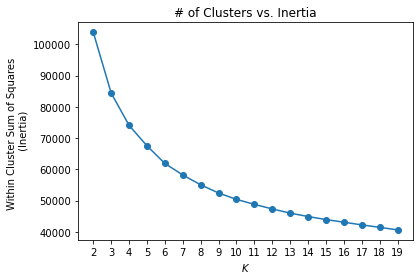

In [24]:
plt.plot(K_range, wcss, marker='o')
plt.xticks(K_range)
plt.title("# of Clusters vs. Inertia")
plt.xlabel('$K$')
plt.ylabel('Within Cluster Sum of Squares \n (Inertia)')
plt.show()

It is difficult to determine from the plot the best value of K as there is not a clear "elbow". Let's try the silhouette method

**Silhouette Method**

The silhouette method uses what is know as a silhouette coefficient to determine the best number of clusters. The silhouette coefficient has values ranging from 0 to 1

For n_clusters = 2 The average silhouette_score is : 0.27015738286673474
For n_clusters = 3 The average silhouette_score is : 0.2562569886056453
For n_clusters = 4 The average silhouette_score is : 0.20739190768888868
For n_clusters = 5 The average silhouette_score is : 0.21413571361870604
For n_clusters = 6 The average silhouette_score is : 0.22569990690954173
For n_clusters = 7 The average silhouette_score is : 0.22157499424917113
For n_clusters = 8 The average silhouette_score is : 0.20817235697540995
For n_clusters = 9 The average silhouette_score is : 0.20828126343058062
For n_clusters = 10 The average silhouette_score is : 0.21070802846962286
For n_clusters = 11 The average silhouette_score is : 0.20834942864300554
For n_clusters = 12 The average silhouette_score is : 0.20277272022580536
For n_clusters = 13 The average silhouette_score is : 0.19635450519939035
For n_clusters = 14 The average silhouette_score is : 0.19720795658548415
For n_clusters = 15 The average silhouette_scor

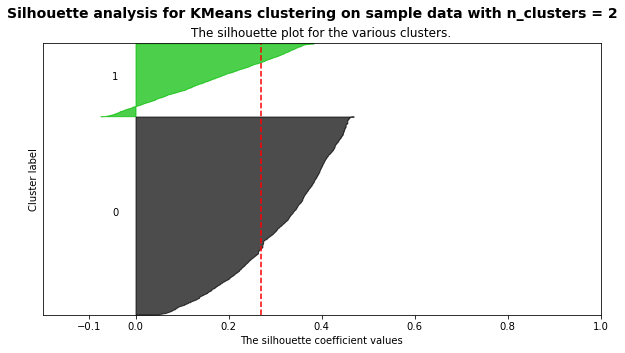

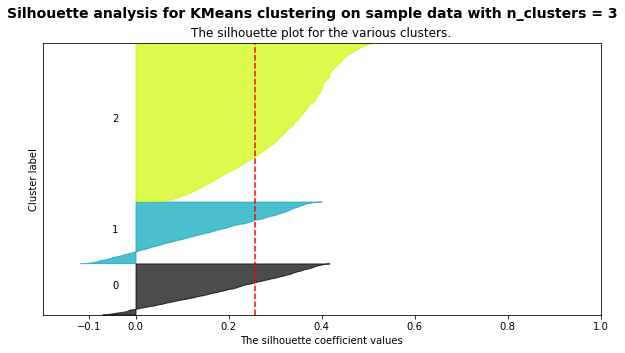

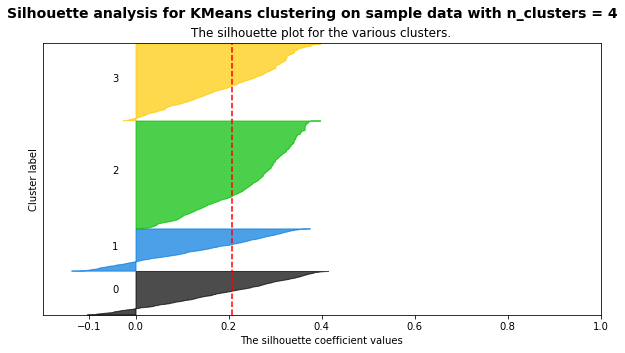

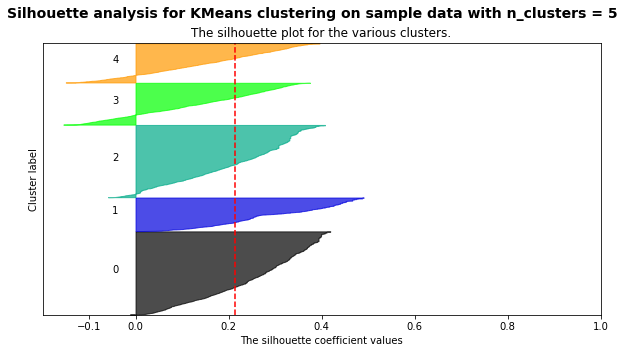

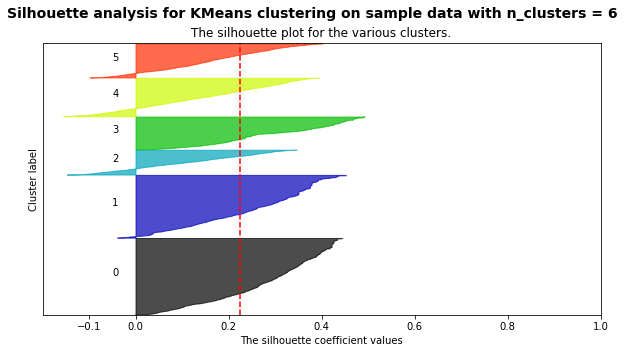

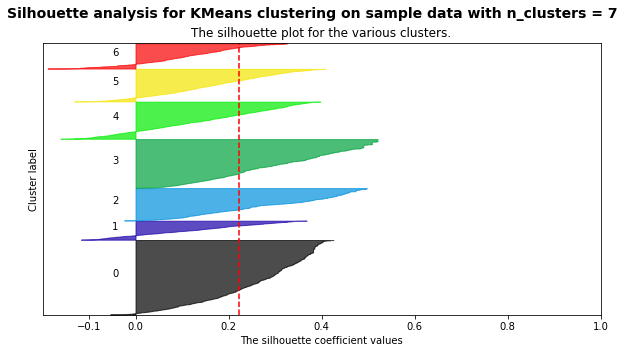

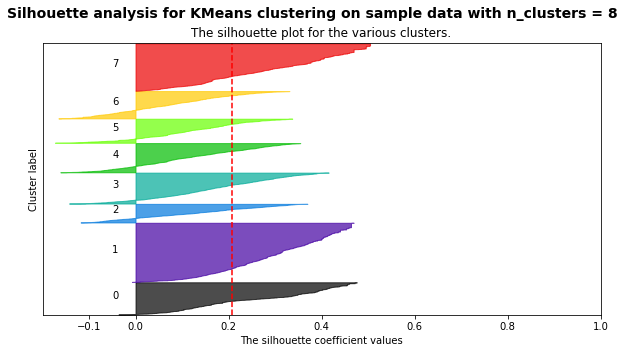

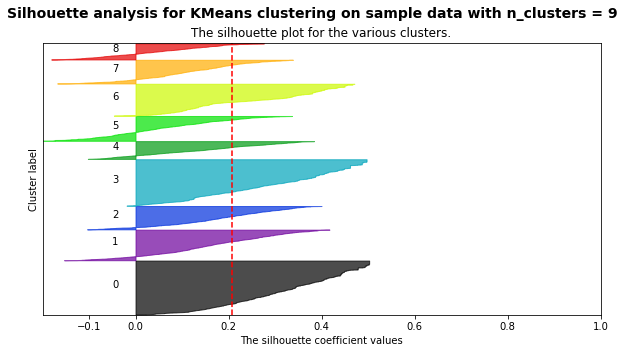

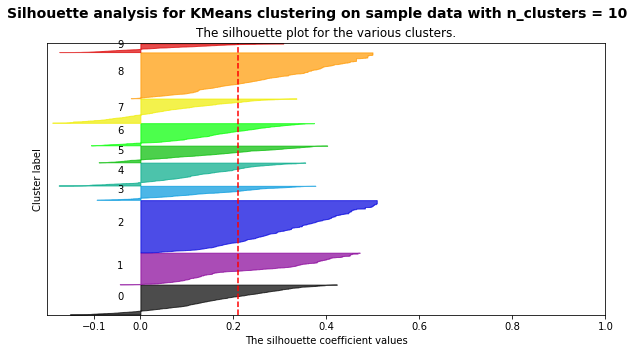

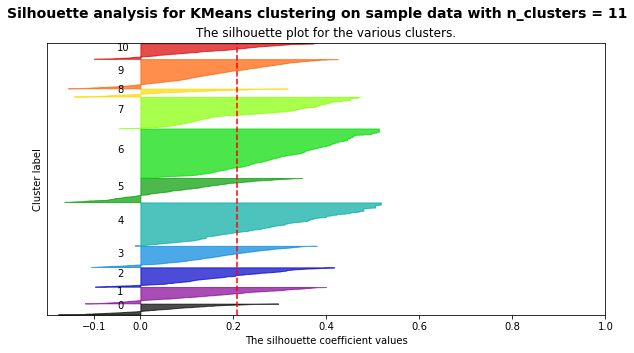

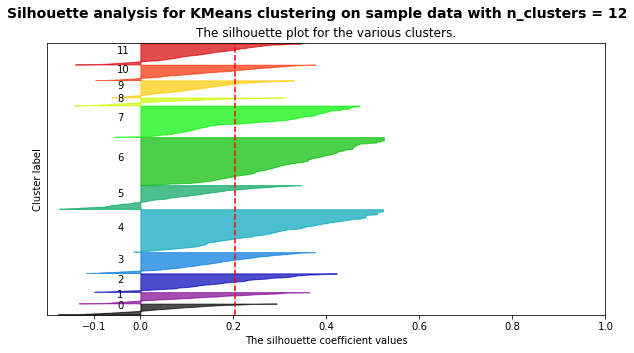

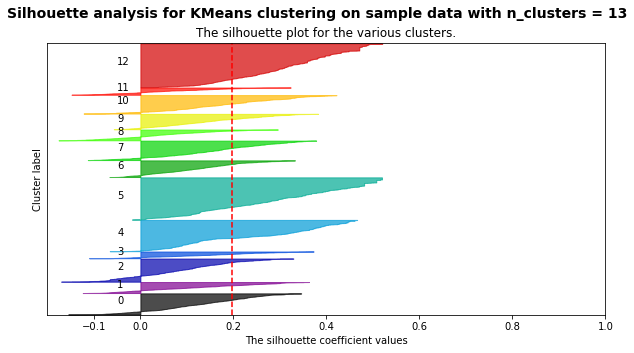

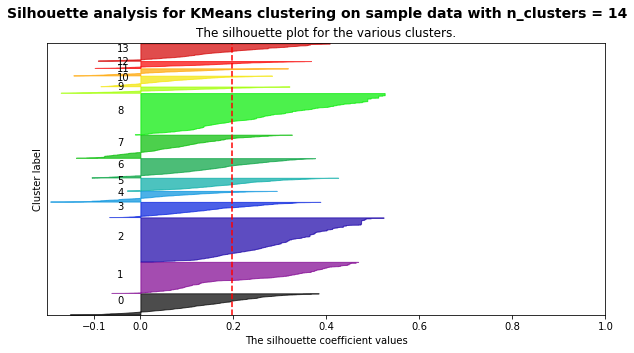

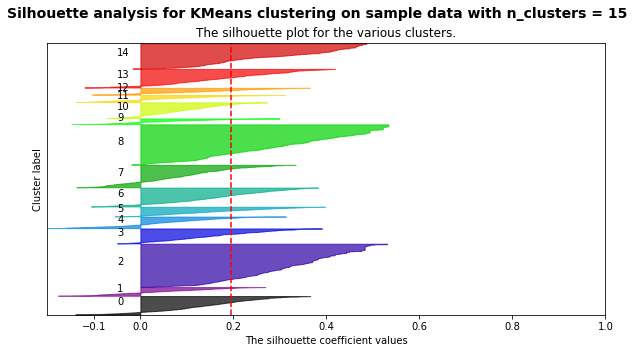

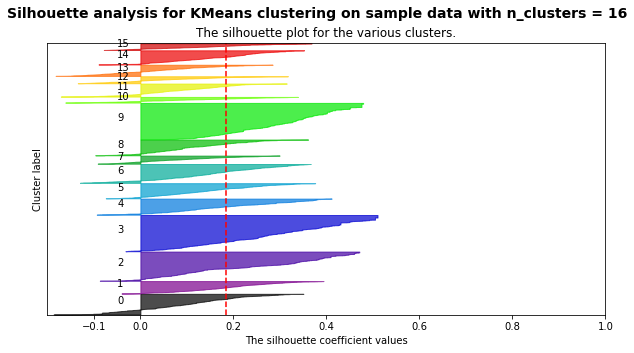

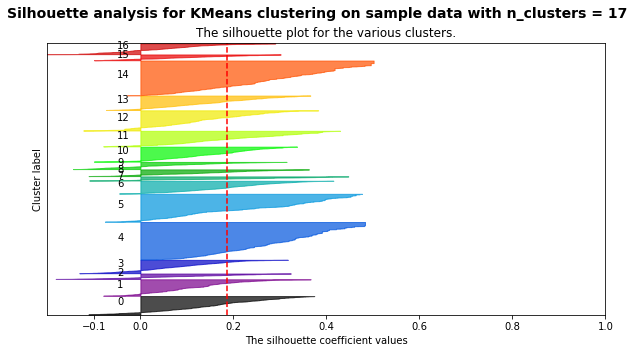

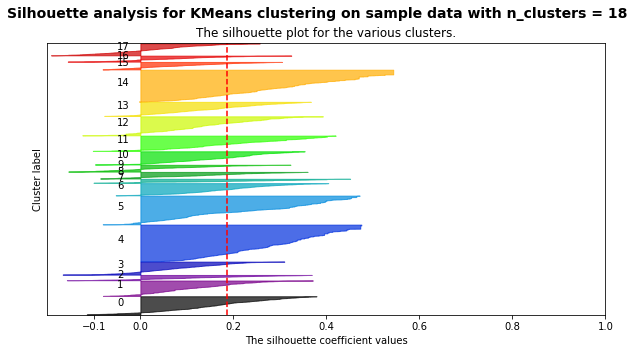

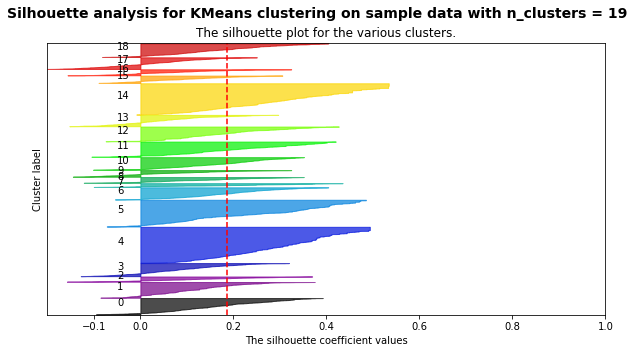

In [25]:
'''
Sci-kit learn offers a hadny function to the retrieve silhoutte score. 
The block of code is adapted from a sci-kit learn article on selecting the number of clusters
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
'''

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

avg_silhouette_scores = []

for n_clusters in K_range:
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(10, 5)
    
     # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1)* 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    avg_silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

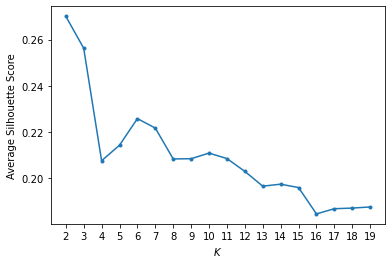

In [26]:
plt.plot(K_range, avg_silhouette_scores, marker='.')
plt.xlabel('$K$')
plt.ylabel('Average Silhouette Score')
plt.xticks(K_range)
plt.show()

Let's set K equal to 3 for now

In [27]:
K = 6

In [28]:
model = KMeans(n_clusters=K, random_state=42)
cluster_labels = model.fit_predict(X)

In [29]:
cc['clusters']= cluster_labels
cc.head()

<ipython-input-29-818b50e606e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['clusters']= cluster_labels


PURCHASES_INSTALLMENTS_FREQUENCY_BIN CREDIT_LIMIT_BIN  \
CUST_ID                                                         
C10001                                     1                2   
C10002                                     1                6   
C10003                                     1                6   
C10004                                     1                6   
C10005                                     1                3   

        BALANCE_FREQUENCY_BIN cc_utilization_BIN MINIMUM_PAYMENTS_BIN  \
CUST_ID                                                                 
C10001                      5                  1                    1   
C10002                      5                  1                    3   
C10003                      5                  1                    2   
C10004                      4                  1                    2   
C10005                      5                  1                    1   

        CASH_ADVANCE_FREQUENCY_BIN BALANCE_BIN PAYMENTS_BIN  \
CUST_ID                                                       
C10001                           1           1            1   
C10002                           2           4            5   
C10003                           1           4            2   
C10004                           1           3            1   
C10005                           1           2            2   

        ONEOFF_PURCHASES_BIN CASH_ADVANCE_BIN INSTALLMENTS_PURCHASES_BIN  \
CUST_ID                                                                    
C10001                     1                1                          1   
C10002                     1                6                          1   
C10003                     2                1                          1   
C10004                     3                1                          1   
C10005                     1                1                          1   

        PURCHASES_TRX_BIN ONEOFF_PURCHASES_FREQUENCY_BIN CASH_ADVANCE_TRX_BIN  \
CUST_ID                                                                         
C10001                  1                              1                    1   
C10002                  1                              1                    1   
C10003                  2                              5                    1   
C10004                  1                              1                    1   
C10005                  1                              1                    1   

        PURCHASES_BIN PURCHASES_FREQUENCY_BIN  clusters  
CUST_ID                                                  
C10001              1                       1         3  
C10002              1                       1         2  
C10003              2                       5         4  
C10004              3                       1         3  
C10005              1                       1         3

# PCA
Principal Component Analysis is useful tool for visualization purpose. It allows for easy visualions of high dimensional data into 2 or 3 principal compoents. It does so by reducing the features through creating new independent features that are a combination of the old features. The downside is it does affect interpretability. In this notebook, we will utilize PCA for visualizing our custers in 2 and 3 dimensions. 

**Scree Plot**

In [30]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

Text(0, 0.5, 'Propotion of Variance Explained')

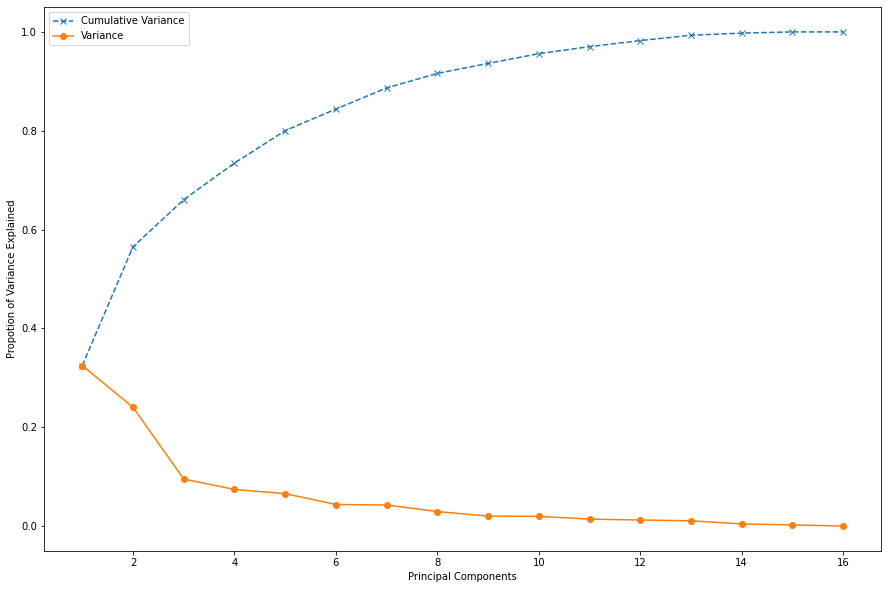

In [31]:
plt.figure(figsize =[15,10])
plt.plot(range(1, X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), marker='x', linestyle='--',label='Cumulative Variance')
plt.plot(range(1, X.shape[1]+1), pca.explained_variance_ratio_, marker='o', label='Variance')
plt.legend()
plt.xlabel('Principal Components')
plt.ylabel('Propotion of Variance Explained')

The steepest drops are from 1 to 2 and 2 to 3. We will visualize our data using both 2 and 3 prinicipal components

**PCA Visualization in 2-D**

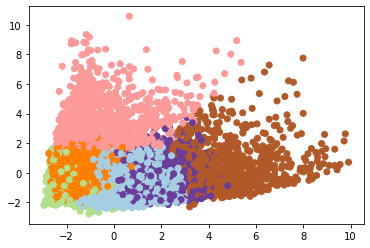

In [32]:
import matplotlib.colors

#PCA
pca = PCA(n_components=2)
pca_transform = pca.fit_transform(X)
pc1, pc2 = zip(*pca_transform)

#Scatter plot
plt.scatter(pc1, pc2, c=cluster_labels, cmap='Paired')
plt.show()

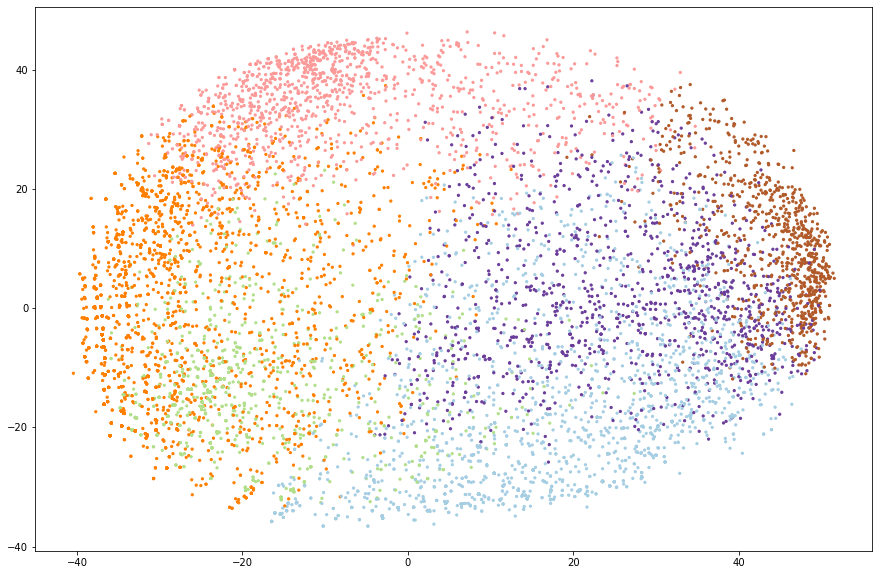

In [33]:
import matplotlib.colors
from sklearn.metrics.pairwise import cosine_similarity

#PCA
distance = 1 - cosine_similarity(X) #Computes pairwsie similarities bewteen all samples in X

pca = PCA(n_components=2)
pca_transform = pca.fit_transform(distance)
pc1, pc2 = zip(*pca_transform)

#Scatter plot
plt.figure(figsize=[15,10])
plt.scatter(pc1, pc2, c=cluster_labels, cmap='Paired', s=5)
plt.show()

**PCA Visualization in 3-D**

In [34]:
import plotly.graph_objs as go
import plotly.offline as pyoff # module for working offline. Generate graphs offline and save them in locally

In [35]:
#PCA
pca = PCA(n_components=3)
pca_transform = pca.fit_transform(X) #transformed features
pc1, pc2, pc3 = zip(*pca_transform) # unpack principal components

df_plot = pd.DataFrame({'pc1': pc1, 'pc2':pc2, 'pc3':pc3, 'cluster_labels':cluster_labels})


In [36]:
df_plot['cluster_labels'].value_counts()

3    2541
0    2084
2    1277
4    1133
1    1091
5     824
Name: cluster_labels, dtype: int64

In [37]:
df_plot['cluster_labels'] = df_plot['cluster_labels'].astype('category')

In [38]:
import plotly.express as px
fig = px.scatter_3d(df_plot, x='pc1', y='pc2', z='pc3', color='cluster_labels', 
                    opacity=0.5,hover_name='cluster_labels', color_discrete_sequence=px.colors.qualitative.Dark2, 
                    category_orders={'cluster labels':[i for i in np.arange(K)]},
                    title='3-D Vizualization of Principal Components',            
                   )

fig.update_traces(marker=dict(size=3.5,))

fig.show()

In [39]:
#PCA
distance = 1 - cosine_similarity(X) #Computes pairwsie similarities bewteen all samples in X

pca = PCA(n_components=3)
pca_transform = pca.fit_transform(distance) #transformed features
pc1, pc2, pc3 = zip(*pca_transform) # unpack principal components

df_plot = pd.DataFrame({'pc1': pc1, 'pc2':pc2, 'pc3':pc3, 'cluster_labels':cluster_labels})

In [40]:
df_plot['cluster_labels'] = df_plot['cluster_labels'].astype('category')

In [41]:
import plotly.express as px

fig = px.scatter_3d(df_plot, x='pc1', y='pc2', z='pc3', color='cluster_labels', 
                    opacity=0.5,hover_name='cluster_labels', color_discrete_sequence=px.colors.qualitative.Dark2, 
                    category_orders={'cluster labels':[i for i in np.arange(K)]},
                    title='3-D Vizualization of Principal Components',            
                   )

fig.update_traces(marker=dict(size=3.5,))

fig.show()

# Profiling The clusters

In [42]:
cc.groupby('clusters')['clusters'].count()

clusters
0    2084
1    1091
2    1277
3    2541
4    1133
5     824
Name: clusters, dtype: int64